In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi
!pip install requests tqdm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
import pathlib
import requests
import zipfile
import os
from tqdm import tqdm

def download_maestro_dataset(data_dir: str = 'data/maestro-v2.0.0') -> pathlib.Path:
    data_dir = pathlib.Path(data_dir)
    zip_path = pathlib.Path('data/maestro-v2.0.0-midi.zip')

    data_dir.parent.mkdir(parents=True, exist_ok=True)

    if data_dir.exists():
        print(f"Dataset already exists at {data_dir}")
        return data_dir

    url = "https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip"
    print(f"Downloading MAESTRO dataset from {url}")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB

    with open(zip_path, 'wb') as f, tqdm(
        desc="Downloading",
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for data in response.iter_content(block_size):
            size = f.write(data)
            pbar.update(size)

    print(f"Extracting dataset to {data_dir.parent}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir.parent)

    zip_path.unlink()

    print(f"Dataset ready at {data_dir}")
    return data_dir

In [ ]:
data_dir = download_maestro_dataset()

Downloading: 100%|██████████| 56.5M/56.5M [00:00<00:00, 77.0MiB/s]


Extracting dataset to data
Dataset ready at data/maestro-v2.0.0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pretty_midi
import pandas as pd
import numpy as np
import collections
import pathlib
import glob
from typing import Optional, Tuple

class MIDIDataset(Dataset):
    def __init__(self, notes_data: np.ndarray, seq_length: int, vocab_size: int = 128):
        self.notes_data = notes_data
        self.seq_length = seq_length
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.notes_data) - self.seq_length

    def __getitem__(self, idx):
        sequence = self.notes_data[idx:idx + self.seq_length]
        target = self.notes_data[idx + self.seq_length]

        sequence = sequence / np.array([self.vocab_size, 1.0, 1.0])

        sequence = torch.FloatTensor(sequence)
        target_pitch = torch.LongTensor([target[0]])
        target_step = torch.FloatTensor([target[1]])
        target_duration = torch.FloatTensor([target[2]])

        return sequence, {'pitch': target_pitch, 'step': target_step, 'duration': target_duration}


In [ ]:

class MusicRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, vocab_size: int):
        super(MusicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.pitch_layer = nn.Linear(hidden_size, vocab_size)
        self.step_layer = nn.Linear(hidden_size, 1)
        self.duration_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        last_output = lstm_out[:, -1, :]

        pitch_logits = self.pitch_layer(last_output)
        step = self.step_layer(last_output)
        duration = self.duration_layer(last_output)

        return {
            'pitch': pitch_logits,
            'step': step,
            'duration': duration
        }

In [ ]:

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,
) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(instrument_name))

    prev_start = 0
    for _, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note_obj = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note_obj)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

def mse_with_positive_pressure(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    mse = (target - pred) ** 2
    positive_pressure = 10 * torch.maximum(-pred, torch.zeros_like(pred))
    return torch.mean(mse + positive_pressure)

def predict_next_note(
    notes: torch.Tensor,
    model: MusicRNN,
    temperature: float = 1.0
) -> Tuple[int, float, float]:
    model.eval()
    with torch.no_grad():
        inputs = notes.unsqueeze(0)

        device = next(model.parameters()).device
        inputs = inputs.to(device)

        predictions = model(inputs)

        pitch_logits = predictions['pitch'] / temperature
        pitch_probs = torch.softmax(pitch_logits, dim=-1)
        pitch = torch.multinomial(pitch_probs, num_samples=1).item()

        step = max(0, predictions['step'].item())
        duration = max(0, predictions['duration'].item())

    return pitch, step, duration


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def train_model(
    model: MusicRNN,
    train_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: torch.device,
    checkpoint_path: str = 'checkpoint.pth'
) -> list:
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    pitch_criterion = nn.CrossEntropyLoss()
    losses = []

    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        losses = checkpoint['loss']
        print(f"Resumed training from epoch {start_epoch}.")

    model.train()
    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0
        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences = sequences.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}

            optimizer.zero_grad()

            predictions = model(sequences)

            pitch_loss = pitch_criterion(predictions['pitch'], targets['pitch'].squeeze())
            step_loss = mse_with_positive_pressure(predictions['step'], targets['step'])
            duration_loss = mse_with_positive_pressure(predictions['duration'], targets['duration'])
            total_loss = 0.05 * pitch_loss + step_loss + duration_loss

            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': losses
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")

    return losses

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
filenames = glob.glob(str(data_dir/'**/*.mid*'))

num_files = 30
all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

seq_length = 25
vocab_size = 128
batch_size = 64

dataset = MIDIDataset(train_notes, seq_length, vocab_size)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
input_size = 3  # pitch, step, duration
hidden_size = 128
model = MusicRNN(input_size, hidden_size, vocab_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 27
learning_rate = 0.005

losses = train_model(model, train_loader, num_epochs, learning_rate, device)

Epoch 1/27, Loss: 0.3322
Epoch 2/27, Loss: 0.3218
Epoch 3/27, Loss: 0.3170
Epoch 4/27, Loss: 0.3138
Epoch 5/27, Loss: 0.3103
Epoch 6/27, Loss: 0.3086
Epoch 7/27, Loss: 0.3072
Epoch 8/27, Loss: 0.3045
Epoch 9/27, Loss: 0.3029
Epoch 10/27, Loss: 0.3027
Checkpoint saved at checkpoint.pth
Epoch 11/27, Loss: 0.3019
Epoch 12/27, Loss: 0.3006
Epoch 13/27, Loss: 0.2993
Epoch 14/27, Loss: 0.2974
Epoch 15/27, Loss: 0.2958
Epoch 16/27, Loss: 0.2965
Epoch 17/27, Loss: 0.2962
Epoch 18/27, Loss: 0.2935
Epoch 19/27, Loss: 0.2933
Epoch 20/27, Loss: 0.2918
Checkpoint saved at checkpoint.pth
Epoch 21/27, Loss: 0.2904
Epoch 22/27, Loss: 0.2886
Epoch 23/27, Loss: 0.2900
Epoch 24/27, Loss: 0.2899
Epoch 25/27, Loss: 0.2949
Epoch 26/27, Loss: 0.3022
Epoch 27/27, Loss: 0.3009
Checkpoint saved at checkpoint.pth


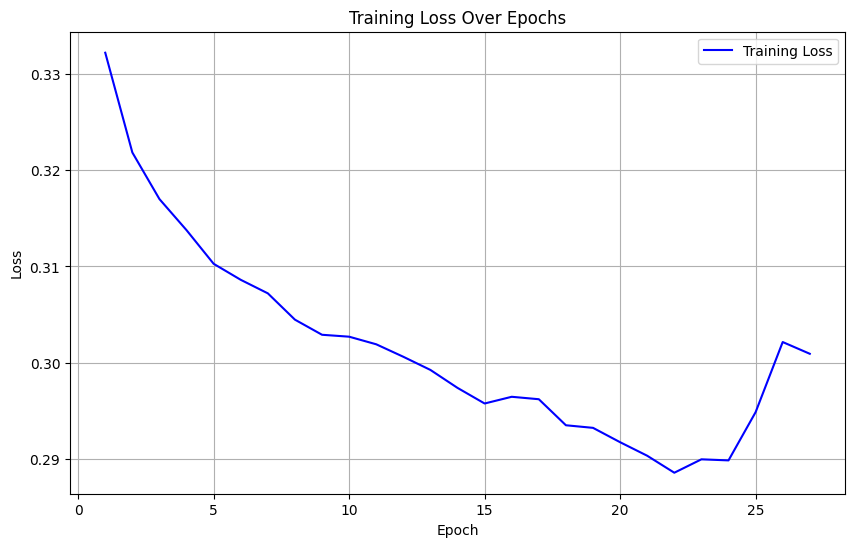

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def generate_music(model, seed_notes, num_predictions=120, temperature=2.0):
    generated_notes = []
    prev_start = 0

    input_notes = torch.FloatTensor(seed_notes / np.array([vocab_size, 1, 1]))

    device = next(model.parameters()).device
    input_notes = input_notes.to(device)

    for _ in range(num_predictions):
        pitch, step, duration = predict_next_note(input_notes, model, temperature)
        start = prev_start + step
        end = start + duration

        generated_notes.append((pitch, step, duration, start, end))

        input_notes = input_notes[1:]
        new_note = torch.FloatTensor([[pitch/vocab_size, step, duration]]).to(device)
        input_notes = torch.cat([input_notes, new_note])

        prev_start = start

    return pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))
sample_notes = train_notes[:seq_length]
generated_notes = generate_music(model, sample_notes)

out_file = 'generated_music.mid'
out_pm = notes_to_midi(generated_notes, out_file, 'Acoustic Grand Piano')